markdown testing

We begin by loading the data and viewing the dataframe

In [4]:
import pandas as pd

# Load the CSV file 
file_path = r'C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\data\FAQ_extracted.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the data structure
df.head()


,Question,Answer
0,Why was the shift to Universal Health Coverage...,To ensure that all Kenyans have access to qual...
1,What is Social Health Insurance (SHI)?,It is a form of health financing mechanism bas...
2,What are the Principles of Social Health Insur...,"Accessible, quality, affordable healthcare ser..."
3,Why is Social Health Insurance important?,An efficient way of managing health funds – ab...
4,What are the 4 Health Laws?,1. The Social Health Insurance Law (2023) – Cr...


After loading the data, we need to add a `Category` column based on question ranges. This column will help group questions by themes (A-I), making intent creation easier.


In [16]:
# Define the category assignments based on question ranges
df['Category'] = ''  # Initialize the 'Category' column

# Assign categories based on the question ranges
df.loc[0:3, 'Category'] = 'Understanding Social Health Authority (SHA)'       # Questions 1 - 4
df.loc[4:17, 'Category'] = 'Institutions Created by UHC Laws and Transition'  # Questions 5 - 18
df.loc[18:23, 'Category'] = 'NHIF Staff Considerations During Transition'     # Questions 19 - 24
df.loc[24:30, 'Category'] = 'Primary Health Care & the PHC Fund'              # Questions 25 - 31
df.loc[31:35, 'Category'] = 'Emergency, Chronic, and Critical Illness Fund'   # Questions 32 - 36
df.loc[36:71, 'Category'] = 'Registration, Means Testing & Contributions'     # Questions 37 - 72
df.loc[72:83, 'Category'] = 'Benefits, Tariffs & Claims Management'           # Questions 73 - 84
df.loc[84:90, 'Category'] = 'Access & Quality of Service Provision'           # Questions 85 - 91
df.loc[91:92, 'Category'] = 'Feedback and Dispute Resolution'                 # Questions 92 - 93

# Check the DataFrame to verify the changes
df.head()



,Question,Answer,Category
0,Why was the shift to Universal Health Coverage...,To ensure that all Kenyans have access to qual...,Understanding Social Health Authority (SHA)
1,What is Social Health Insurance (SHI)?,It is a form of health financing mechanism bas...,Understanding Social Health Authority (SHA)
2,What are the Principles of Social Health Insur...,"Accessible, quality, affordable healthcare ser...",Understanding Social Health Authority (SHA)
3,Why is Social Health Insurance important?,An efficient way of managing health funds – ab...,Understanding Social Health Authority (SHA)
4,What are the 4 Health Laws?,1. The Social Health Insurance Law (2023) – Cr...,Institutions Created by UHC Laws and Transition


In [68]:
file_path = r"C:\Users\GeorgeC\Downloads\questions_list.csv"
df.to_csv(file_path, index=False)


After labeling questions into categories, we clean the `Question` column by converting text to lowercase, removing punctuation, and preserving only four-digit numbers (years) to maintain consistent formatting for intent recognition.


In [17]:
import re

# Convert questions to lowercase
df['Question'] = df['Question'].str.lower()

# Remove all punctuation and special characters, but keep four-digit years
df['Question'] = df['Question'].apply(lambda x: re.sub(r'[^a-zA-Z\s]|\b(?!\d{4}\b)\b\d+\b', '', x))

# Remove duplicates based on the 'Question' column
df.drop_duplicates(subset='Question', inplace=True)

# Check the cleaned data
df.head()


,Question,Answer,Category
0,why was the shift to universal health coverage...,To ensure that all Kenyans have access to qual...,Understanding Social Health Authority (SHA)
1,what is social health insurance shi,It is a form of health financing mechanism bas...,Understanding Social Health Authority (SHA)
2,what are the principles of social health insur...,"Accessible, quality, affordable healthcare ser...",Understanding Social Health Authority (SHA)
3,why is social health insurance important,An efficient way of managing health funds – ab...,Understanding Social Health Authority (SHA)
4,what are the health laws,1. The Social Health Insurance Law (2023) – Cr...,Institutions Created by UHC Laws and Transition


### Intent and Entity Setup

After cleaning the data, we now define intents based on each category and question. This step involves organizing questions into intent groups (e.g., `ask_sha`, `ask_uhc_institutions`) and preparing example questions for each intent. We save these intents in a `nlu.yml` file, which will guide the model in recognizing user queries accurately.


In [84]:
# Define the YAML content for NLU data
nlu_yml_content = """
version: "3.1"

nlu:
  - intent: greet
    examples: |
      - Hi
      - Hello
      - Hey
      - Good morning
      - Good afternoon
      - Good evening
      - How are you?
      - Hello there

  - intent: goodbye
    examples: |
      - Goodbye
      - Bye
      - See you later
      - Talk to you soon
      - Bye for now
      - Catch you later
      - Have a great day
      - Take care

  - intent: bot_identity
    examples: |
      - Are you a bot?
      - Who are you?
      - Are you human or a machine?
      - What is your purpose?
      - What kind of assistant are you?
      - Can you tell me if you are a real person?

  - intent: why_shift_to_uhc
    examples: |
      - Why was it necessary to implement universal health coverage?
      - Why did Kenya transition to universal health coverage?
      - What led to the shift towards universal health coverage?
      - What was the reason behind the shift to universal health coverage?
      - Why is universal health coverage important for Kenyans?
      - What motivated the move towards universal health coverage in Kenya?

  - intent: what_is_shi
    examples: |
      - What does social health insurance (SHI) mean?
      - Can you explain what SHI is?
      - What is meant by social health insurance?
      - What is social health insurance and how does it work?
      - How does SHI help in managing healthcare?
      - What role does social health insurance play in Kenya's healthcare system?

  - intent: principles_of_shi
    examples: |
      - What are the main principles behind social health insurance?
      - Can you list the key principles of SHI?
      - What principles guide social health insurance?
      - What core values drive the functioning of SHI?
      - What are the foundational principles of social health insurance?
      - What values are upheld by SHI in Kenya?

  - intent: importance_of_shi
    examples: |
      - Why is social health insurance considered important?
      - What makes SHI significant for the healthcare system?
      - How does social health insurance benefit the healthcare sector?
      - Why should we support social health insurance?
      - What are the benefits of adopting social health insurance?
      - How does SHI promote healthcare equity?

  - intent: health_laws_uhc
    examples: |
      - What health laws were established under UHC?
      - Can you explain the health laws related to universal health coverage?
      - What are the key health laws for driving UHC in Kenya?
      - What are the laws enacted for universal health coverage in 2023?
      - What healthcare laws support the development of UHC?
      - What legislation has been introduced to support UHC?

  - intent: reforms_shi_vs_nhif
    examples: |
      - What prompted the proposed reforms towards SHI?
      - Why was SHA created instead of improving NHIF?
      - Why was there a transition to SHA from NHIF?
      - Why were healthcare reforms proposed under SHI?
      - What issues led to the formation of SHA over NHIF?
      - Why was SHA chosen as the new model over NHIF?

  - intent: difference_sha_shif
    examples: |
      - How do SHA and SHIF differ from each other?
      - What distinguishes SHA from SHIF?
      - Can you explain the difference between SHA and SHIF?
      - What roles do SHA and SHIF play, and how are they different?
      - What makes SHA different from SHIF?
      - How does the SHA structure differ from the SHIF structure?

  - intent: nhif_to_sha_transition_process
    examples: |
      - How will the transition from NHIF to SHA happen?
      - What is the process of transitioning from NHIF to SHA?
      - How will NHIF be phased out and replaced by SHA?
      - What are the steps in moving from NHIF to SHA?
      - How will SHA replace NHIF?
      - What should NHIF members expect during the transition to SHA?

  - intent: continuity_of_services
    examples: |
      - How will continuity of services be ensured during the transition?
      - What will be done to ensure Kenyans continue to receive services during the transition?
      - How will the transition from NHIF to SHA impact healthcare access?
      - Will there be service interruptions during the transition to SHA?
      - How is continuity of services being maintained during the transition?
      - What plans are in place to ensure uninterrupted services during the NHIF to SHA transition?

  - intent: what_is_emergency_chronic_fund
    examples: |
      - What is the Emergency, Chronic, and Critical Illness Fund?
      - How does the Emergency, Chronic, and Critical Illness Fund work?
      - Who can benefit from the Emergency, Chronic, and Critical Illness Fund?
      - What is the role of the Emergency, Chronic, and Critical Illness Fund?
      - What healthcare costs are covered by the Emergency, Chronic, and Critical Illness Fund?
      - What services are covered under the Emergency, Chronic, and Critical Illness Fund?

  - intent: staff_affected_transition
    examples: |
      - How will the transition impact NHIF staff?
      - What happens to staff during the transition from NHIF to SHA?
      - Will NHIF staff be absorbed by SHA?
      - How will NHIF employees be affected by the new SHA structure?
      - What is the process for transitioning NHIF employees to SHA?
      - What happens to NHIF staff who do not join SHA?

  - intent: eligibility_sha
    examples: |
      - Who can register for SHA?
      - Who is eligible to join SHA?
      - Can non-Kenyans register for SHA?
      - Is SHA membership open to everyone?
      - What are the eligibility criteria for registering for SHA?
      - Who can become a member of the Social Health Authority?

  - intent: sha_contributions
    examples: |
      - How will contributions be made to SHA?
      - What is the process for contributing to SHA?
      - Who is required to make contributions to SHA?
      - How will salaried employees contribute to SHA?
      - What are the contribution rates for SHA?
      - How will informal sector workers make contributions to SHA?

  - intent: access_primary_health_fund
    examples: |
      - How can I use the Primary Healthcare Fund?
      - When can I access services using the Primary Healthcare Fund?
      - What services are covered by the Primary Healthcare Fund?
      - How do I register for the Primary Healthcare Fund?
      - Who is eligible to use the Primary Healthcare Fund?
      - How will I benefit from the Primary Healthcare Fund?

  - intent: sha_benefits_low_income
    examples: |
      - How does SHA support low-income individuals?
      - What benefits does SHA provide for vulnerable groups?
      - Will SHA help people who can't afford healthcare?
      - How does SHA benefit people with disabilities?
      - What provisions are in place for low-income households under SHA?
      - How does SHA ensure equitable access to healthcare?

  - intent: penalties_for_late_payment
    examples: |
      - Are there penalties for late contributions to SHA?
      - What happens if I miss a payment to SHA?
      - Will there be penalties for not contributing on time?
      - What penalties apply for non-payment of SHA contributions?
      - How can I avoid penalties when contributing to SHA?
      - Is there any consequence for delayed payments to SHA?

  - intent: choose_provider_sha
    examples: |
      - Will I be able to select my healthcare provider under SHA?
      - Can I choose which hospital to go to under SHA?
      - Do SHA members have the freedom to select healthcare providers?
      - Can I decide which healthcare facility I use with SHA?
      - Will SHA allow me to pick my doctor?
      - Can I choose between public and private facilities under SHA?

  - intent: sha_manage_quality
    examples: |
      - What will SHA do to ensure quality of healthcare services?
      - How will SHA maintain a high quality of care in facilities?
      - What measures will SHA take to ensure quality healthcare?
      - How does SHA guarantee quality service provision?
      - Will there be monitoring of quality standards under SHA?
      - How will SHA address quality concerns in healthcare facilities?

  # Additional intents for the missing questions
  - intent: ask_sha
    examples: |
      - What is SHA?
      - Can you tell me about the Social Health Authority?
      - What does SHA do?
      - What is the role of SHA in healthcare?
      - How does the Social Health Authority work?
      - Who manages SHA?

  - intent: ask_uhc_institutions
    examples: |
      - What institutions are involved in UHC?
      - Which organizations play a role in universal health coverage?
      - Who is responsible for implementing UHC in Kenya?
      - What institutions drive universal health coverage?
      - Who manages healthcare institutions under UHC?
      - What organizations are part of the UHC initiative?

  - intent: ask_nhif_transition
    examples: |
      - What happens during the NHIF to SHA transition?
      - How will the NHIF shift to SHA?
      - What will be done to transition NHIF to SHA?
      - What are the transition steps from NHIF to SHA?
      - Is NHIF being replaced by SHA?
      - How will SHA take over from NHIF?

  - intent: ask_phc_fund
    examples: |
      - What is the Primary Healthcare Fund?
      - How does the Primary Healthcare Fund work?
      - Who can benefit from the Primary Healthcare Fund?
      - What does the Primary Healthcare Fund cover?
      - How do I register for the Primary Healthcare Fund?
      - Is the Primary Healthcare Fund part of SHA?

  - intent: ask_emergency_fund
    examples: |
      - What is the emergency fund for healthcare?
      - How does the emergency fund work for chronic illnesses?
      - Can I access the emergency fund in an urgent situation?
      - What are the conditions for accessing the emergency healthcare fund?
      - Who can use the emergency fund for healthcare?
      - Is there a fund for medical emergencies?

  - intent: ask_registration
    examples: |
      - How do I register for SHA?
      - What is the registration process for SHA?
      - Do I need to register for SHA if I have NHIF?
      - How do I sign up for the Social Health Authority?
      - Is registration for SHA mandatory?
      - Where do I go to register for SHA?

  - intent: ask_service_quality
    examples: |
      - How does SHA ensure quality of service?
      - What quality standards are followed under SHA?
      - Will SHA monitor the quality of healthcare services?
      - How is quality maintained in SHA-funded facilities?
      - What is SHA doing about service quality?
      - How does SHA assure quality healthcare?

  - intent: ask_benefits_claims
    examples: |
      - How can I claim benefits under SHA?
      - What is the procedure for claiming health benefits with SHA?
      - How do I make a benefits claim?
      - What is the benefits claim process under SHA?
      - How can I receive benefits from SHA?
      - What steps are involved in claiming health benefits?

  - intent: ask_feedback_resolution
    examples: |
      - How can I file a complaint with SHA?
      - What is the process for giving feedback to SHA?
      - Is there a way to resolve disputes with SHA?
      - How do I report an issue to SHA?
      - Can I give feedback on healthcare quality under SHA?
      - How does SHA handle complaints?

  - intent: bot_challenge
    examples: |
      - Are you real?
      - Can you prove you're not a bot?
      - Are you an AI or a human?
      - How do I know you're not human?
      - You're just a bot, right?
      - Are you a person or a machine?
"""

# Path to save in Google Drive
output_path = r'C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\data\nlu.yml'

# Save to file
with open(output_path, 'w') as file:
    file.write(nlu_yml_content)

print("nlu.yml file created successfully at:", output_path)


nlu.yml file created successfully at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\data\nlu.yml


# Creating `domain.yml` for Rasa Chatbot

After defining `nlu.yml` with intents and questions, we proceed to create `domain.yml`, which configures the chatbot’s responses and intents

The `domain.yml` file helps Rasa:
- Recognize **intents** and map them to responses.
- Store **responses** for each intent.

    



In [85]:
# Define the domain content for Rasa in YAML format as a raw string
domain_yml_content = r"""

version: "3.1"

intents:
  - greet
  - goodbye
  - bot_identity
  - why_shift_to_uhc
  - what_is_shi
  - principles_of_shi
  - importance_of_shi
  - health_laws_uhc
  - reforms_shi_vs_nhif
  - difference_sha_shif
  - nhif_to_sha_transition_process
  - continuity_of_services
  - what_is_emergency_chronic_fund
  - staff_affected_transition
  - eligibility_sha
  - sha_contributions
  - access_primary_health_fund
  - sha_benefits_low_income
  - penalties_for_late_payment
  - choose_provider_sha
  - sha_manage_quality
  - ask_sha
  - ask_uhc_institutions
  - ask_nhif_transition
  - ask_phc_fund
  - ask_emergency_fund
  - ask_registration
  - ask_benefits_claims
  - ask_service_quality
  - ask_feedback_resolution
  - bot_challenge

responses:
  utter_greet:
    - text: "Hello! How can I assist you today?"
    - text: "Hi there! What would you like to know?"
    - text: "Hey! How can I help you today?"

  utter_goodbye:
    - text: "Goodbye! Have a great day!"
    - text: "Bye! Feel free to ask if you have more questions."
    - text: "Take care! See you next time."

  utter_bot_identity:
    - text: "I am a chatbot designed to provide information about the Social Health Authority (SHA) and Universal Health Coverage (UHC) in Kenya. How can I help you today?"
    - text: "I am an automated assistant here to answer your questions about SHA, UHC, and healthcare in Kenya."
    - text: "You are chatting with a bot that can provide information on SHA and health services in Kenya."

  utter_why_shift_to_uhc:
    - text: "The shift to Universal Health Coverage (UHC) was necessary to ensure all Kenyans have access to quality, affordable, and comprehensive health services without financial hardship. It promotes equity and provides access to healthcare for vulnerable groups."

  utter_what_is_shi:
    - text: "Social Health Insurance (SHI) is a healthcare financing mechanism that pools resources to increase efficiency. Individuals pay premiums into a fund that is used to cover healthcare services for all when needed, without financial burden at the point of service."

  utter_principles_of_shi:
    - text: "The core principles of SHI are accessibility, quality, affordability, a well-defined benefit package, mandatory registration and contribution, and equity in healthcare access for all."

  utter_importance_of_shi:
    - text: "SHI is crucial for providing sustainable, equitable healthcare. It ensures funding is based on healthcare needs, reduces costs, and promotes transparency by involving direct contributions from all members."

  utter_health_laws_uhc:
    - text: "The key health laws supporting UHC include: The Social Health Insurance Law, The Digital Health Act, Facility Improvement Financing Law, and the Primary Care Networks Law. These laws help implement and sustain UHC effectively."

  utter_reforms_shi_vs_nhif:
    - text: "The shift to SHA instead of NHIF was motivated by the need to increase efficiency and equity by consolidating fragmented insurance pools. SHA provides a fair and household-based contribution mechanism, making healthcare more accessible."

  utter_difference_sha_shif:
    - text: "SHA is the governing authority managing healthcare funds like the Social Health Insurance Fund (SHIF), Primary Healthcare Fund, and Emergency, Chronic, and Critical Illness Fund. SHIF is just one of the funds SHA manages."

  utter_nhif_to_sha_transition_process:
    - text: "The transition from NHIF to SHA will take place by transferring all rights and duties from NHIF to SHA. The Transition Committee is overseeing this process, which is expected to be complete by July 2024."

  utter_continuity_of_services:
    - text: "Continuity of services is ensured through regulations allowing NHIF contracts and paid-up memberships to stay valid until June 30, 2024. SHA will take over on July 1, 2024, without any service disruptions."

  utter_what_is_emergency_chronic_fund:
    - text: "The Emergency, Chronic, and Critical Illness Fund provides financial support for managing chronic illnesses and emergencies after the Social Health Insurance Fund limits are exhausted. It ensures continued access to healthcare for critical needs."

  utter_staff_affected_transition:
    - text: "SHA will recruit staff based on its new structure. NHIF staff can apply for declared vacancies, with priority given to qualified candidates. Staff who aren't absorbed can either retire voluntarily or be redeployed."

  utter_eligibility_sha:
    - text: "All Kenyans, as well as non-Kenyans residing in Kenya for over 12 months, are eligible and required to register for SHA. NHIF members will need to register afresh for SHA."

  utter_sha_contributions:
    - text: "Contributions to SHA depend on household income. Salaried employees will have monthly deductions, while informal workers contribute annually. The rate is 2.75% of income, ensuring fair and adequate funding."

  utter_access_primary_health_fund:
    - text: "The Primary Healthcare Fund (PHCF) provides essential healthcare services at no extra cost for level 2 and 3 facilities or upon referral by community health promoters. Registration for SHI automatically enrolls you in PHCF."

  utter_sha_benefits_low_income:
    - text: "SHA supports low-income and vulnerable groups by offering government-funded subsidies through means testing. This ensures everyone has access to healthcare, regardless of their financial situation."

  utter_penalties_for_late_payment:
    - text: "If contributions are not paid on time, a 2% penalty is applied to the outstanding amount for each period it remains unpaid. It is important to pay on time to avoid accumulating penalties."

  utter_choose_provider_sha:
    - text: "SHA allows members to choose their healthcare provider from a list of contracted facilities, including public, private, and faith-based providers. Members can select their preferred provider for quality care."

  utter_sha_manage_quality:
    - text: "SHA manages healthcare quality through regulations, including the Quality-of-Care Bill. SHA reimburses based on service quality and implements complaint resolution mechanisms to address any concerns."

  utter_ask_sha:
    - text: "SHA is the Social Health Authority that manages health funds in Kenya."

  utter_ask_uhc_institutions:
    - text: "UHC involves various institutions, including SHA, healthcare facilities, and government bodies."

  utter_ask_nhif_transition:
    - text: "The transition from NHIF to SHA is designed to be seamless with regulatory oversight."

  utter_ask_phc_fund:
    - text: "The Primary Healthcare Fund covers basic healthcare at community levels."

  utter_ask_emergency_fund:
    - text: "The Emergency, Chronic, and Critical Illness Fund is used after exhausting standard SHI limits."

  utter_ask_registration:
    - text: "Registration for SHA is required for all Kenyan residents, and involves simple verification steps."

  utter_ask_benefits_claims:
    - text: "Benefits claims under SHA are processed through empaneled healthcare providers."

  utter_ask_service_quality:
    - text: "SHA ensures service quality by monitoring provider performance and patient satisfaction."

  utter_ask_feedback_resolution:
    - text: "SHA has a complaint resolution process based on the Mwongozo governance code."

  utter_iamabot:
    - text: "I am a virtual assistant designed to help you with questions about healthcare in Kenya."

actions:
  - utter_greet
  - utter_goodbye
  - utter_bot_identity
  - utter_why_shift_to_uhc
  - utter_what_is_shi
  - utter_principles_of_shi
  - utter_importance_of_shi
  - utter_health_laws_uhc
  - utter_reforms_shi_vs_nhif
  - utter_difference_sha_shif
  - utter_nhif_to_sha_transition_process
  - utter_continuity_of_services
  - utter_what_is_emergency_chronic_fund
  - utter_staff_affected_transition
  - utter_eligibility_sha
  - utter_sha_contributions
  - utter_access_primary_health_fund
  - utter_sha_benefits_low_income
  - utter_penalties_for_late_payment
  - utter_choose_provider_sha
  - utter_sha_manage_quality
  - utter_ask_sha
  - utter_ask_uhc_institutions
  - utter_ask_nhif_transition
  - utter_ask_phc_fund
  - utter_ask_emergency_fund
  - utter_ask_registration
  - utter_ask_benefits_claims
  - utter_ask_service_quality
  - utter_ask_feedback_resolution
  - utter_iamabot

"""

# Save to a file
output_path = r'C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\data\domain.yml'
with open(output_path, 'w') as file:
    file.write(domain_yml_content)

print(f"domain.yml file has been saved at: {output_path}")


domain.yml file has been saved at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\data\domain.yml


# Creating stories.yml

Here, we create the `stories.yml` file, which defines the flow of conversations for the chatbot. it  Maps out sequences of intents and responses, enabling the bot to manage conversational paths. This structure allows the chatbot to handle multi-step conversations and deliver responses based on the user’s context.


In [86]:
# Define the stories content for Rasa in YAML format
stories_yml_content = """
version: "3.1"

stories:
  - story: Greeting
    steps:
      - intent: greet
      - action: utter_greet

  - story: Farewell
    steps:
      - intent: goodbye
      - action: utter_goodbye

  - story: Bot Identity Inquiry
    steps:
      - intent: bot_identity
      - action: utter_bot_identity

  - story: Universal Health Coverage Shift
    steps:
      - intent: why_shift_to_uhc
      - action: utter_why_shift_to_uhc

  - story: Social Health Insurance Inquiry
    steps:
      - intent: what_is_shi
      - action: utter_what_is_shi

  - story: Principles of SHI
    steps:
      - intent: principles_of_shi
      - action: utter_principles_of_shi

  - story: Importance of SHI
    steps:
      - intent: importance_of_shi
      - action: utter_importance_of_shi

  - story: Health Laws Supporting UHC
    steps:
      - intent: health_laws_uhc
      - action: utter_health_laws_uhc

  - story: Reforms from NHIF to SHA
    steps:
      - intent: reforms_shi_vs_nhif
      - action: utter_reforms_shi_vs_nhif

  - story: Difference Between SHA and SHIF
    steps:
      - intent: difference_sha_shif
      - action: utter_difference_sha_shif

  - story: NHIF to SHA Transition Process
    steps:
      - intent: nhif_to_sha_transition_process
      - action: utter_nhif_to_sha_transition_process

  - story: Continuity of Services During Transition
    steps:
      - intent: continuity_of_services
      - action: utter_continuity_of_services

  - story: Emergency Chronic Fund Inquiry
    steps:
      - intent: what_is_emergency_chronic_fund
      - action: utter_what_is_emergency_chronic_fund

  - story: Impact on Staff During Transition
    steps:
      - intent: staff_affected_transition
      - action: utter_staff_affected_transition

  - story: SHA Eligibility
    steps:
      - intent: eligibility_sha
      - action: utter_eligibility_sha

  - story: Contributions to SHA
    steps:
      - intent: sha_contributions
      - action: utter_sha_contributions

  - story: Accessing Primary Health Fund
    steps:
      - intent: access_primary_health_fund
      - action: utter_access_primary_health_fund

  - story: Benefits for Low-Income Individuals
    steps:
      - intent: sha_benefits_low_income
      - action: utter_sha_benefits_low_income

  - story: Penalties for Late Payments
    steps:
      - intent: penalties_for_late_payment
      - action: utter_penalties_for_late_payment

  - story: Choosing Provider Under SHA
    steps:
      - intent: choose_provider_sha
      - action: utter_choose_provider_sha

  - story: Managing Quality Under SHA
    steps:
      - intent: sha_manage_quality
      - action: utter_sha_manage_quality

  - story: Understanding SHA
    steps:
      - intent: ask_sha
      - action: utter_ask_sha

  - story: UHC Institutions Inquiry
    steps:
      - intent: ask_uhc_institutions
      - action: utter_ask_uhc_institutions

  - story: NHIF Transition Inquiry
    steps:
      - intent: ask_nhif_transition
      - action: utter_ask_nhif_transition

  - story: Primary Health Care Fund Inquiry
    steps:
      - intent: ask_phc_fund
      - action: utter_ask_phc_fund

  - story: Emergency Fund Inquiry
    steps:
      - intent: ask_emergency_fund
      - action: utter_ask_emergency_fund

  - story: SHA Registration Inquiry
    steps:
      - intent: ask_registration
      - action: utter_ask_registration

  - story: Benefits Claims Inquiry
    steps:
      - intent: ask_benefits_claims
      - action: utter_ask_benefits_claims

  - story: Service Quality Inquiry
    steps:
      - intent: ask_service_quality
      - action: utter_ask_service_quality

  - story: Feedback and Resolution Inquiry
    steps:
      - intent: ask_feedback_resolution
      - action: utter_ask_feedback_resolution

  - story: Bot Challenge
    steps:
      - intent: bot_challenge
      - action: utter_iamabot
"""

# Save the stories file as stories.yml
output_path = r'C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\data\stories.yml'

# Write the content to the specified file path
with open(output_path, 'w') as file:
    file.write(stories_yml_content)

print(f"stories.yml file has been saved at: {output_path}")


stories.yml file has been saved at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\data\stories.yml


# Model Training and Evaluation in Rasa

Here we now document the training, evaluation, and visualization of our Rasa model to track our process for future reference and project documentation.


## 1. Model Training

Model training is conducted in the terminal using the command below. This command specifies paths for the configuration, domain, and data to train both the NLU and Core models.

```bash
rasa train --config "C:\\Users\\GeorgeC\\Documents\\Flatiron\\phase5\\capstone_project\\capstone_project\\chira\\rasa_project_files\\config.yml" \
--domain "C:\\Users\\GeorgeC\\Documents\\Flatiron\\phase5\\capstone_project\\capstone_project\\chira\\rasa_project_files\\data\\domain.yml" \
--data "C:\\Users\\GeorgeC\\Documents\\Flatiron\\phase5\\capstone_project\\capstone_project\\chira\\rasa_project_files\\data"
```

### NLU Model Evaluation 

The NLU evaluation assesses intent classification and entity extraction accuracy against the NLU test data:

```bash
$ rasa test nlu --nlu "C:/Users/GeorgeC/Documents/Flatiron/phase5/capstone_project/capstone_project/chira/rasa_project_files/data/test_nlu.yml" --domain "C:/Users/GeorgeC/Documents/Flatiron/phase5/capstone_project/capstone_project/chira/rasa_project_files/data/domain.yml
```

### Plotting F1 Scores for Intent Evaluation

After training and testing the Rasa NLU model, we use the following code to plot a histogram of F1 scores for each intent. This visualization helps us assess how well the model recognizes each intent and identify areas for improvement.



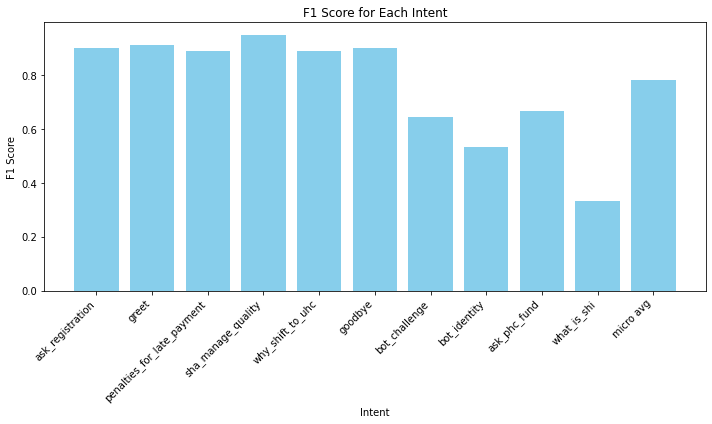

Histogram saved at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\results\intent_histogram.png


In [87]:
import json
import matplotlib.pyplot as plt

# Load the intent report
report_path = r"C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\results\intent_report.json"

try:
    with open(report_path, "r") as f:
        report = json.load(f)

    # Extract intent names and F1 scores
    intents = []
    f1_scores = []

    for intent, metrics in report.items():
        if intent not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip summary metrics
            intents.append(intent)
            f1_scores.append(float(metrics['f1-score']))

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(intents, f1_scores, color='skyblue')
    plt.xlabel('Intent')
    plt.ylabel('F1 Score')
    plt.title('F1 Score for Each Intent')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save the histogram
    histogram_path = r"C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\results\intent_histogram.png"
    plt.savefig(histogram_path)

    # Display in notebook
    plt.show()

    print(f"Histogram saved at: {histogram_path}")

except FileNotFoundError:
    print(f"File not found: {report_path}")
except json.JSONDecodeError:
    print(f"Error decoding JSON from: {report_path}")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")



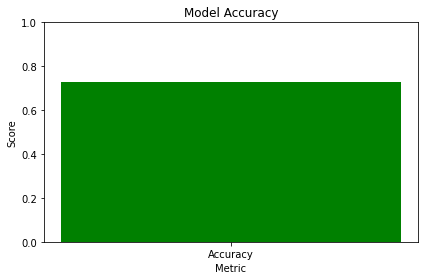

Accuracy plot saved at: C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\results\accuracy_plot.png


In [97]:
import json
import matplotlib.pyplot as plt

# Load the intent report
report_path = r"C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\results\intent_report.json"

try:
    with open(report_path, "r") as f:
        report = json.load(f)

    # Extract overall accuracy
    accuracy = report.get('accuracy', None)

    # Check if accuracy is available
    if accuracy is not None:
        # Plot accuracy
        plt.figure(figsize=(6, 4))
        plt.bar(['Accuracy'], [accuracy], color='green')
        plt.xlabel('Metric')
        plt.ylabel('Score')
        plt.title('Model Accuracy')
        plt.ylim(0, 1)  # Accuracy is between 0 and 1 for a percentage representation
        plt.tight_layout()

        # Save the accuracy plot
        accuracy_plot_path = r"C:\Users\GeorgeC\Documents\Flatiron\phase5\capstone_project\capstone_project\chira\rasa_project_files\results\accuracy_plot.png"
        plt.savefig(accuracy_plot_path)

        # Display the plot in the notebook
        plt.show()

        print(f"Accuracy plot saved at: {accuracy_plot_path}")

    else:
        print("Accuracy value not found in the report.")

except FileNotFoundError:
    print(f"File not found: {report_path}")
except json.JSONDecodeError:
    print(f"Error decoding JSON from: {report_path}")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")
